# Email summarization with Langchain Map Reduce and Azure Open AI

In [4]:
import extract_msg
import glob
import openai
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import textwrap
import tiktoken

from datetime import datetime
from dotenv import load_dotenv
from langchain import OpenAI, LLMChain
from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [6]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


## Fields extractions from emails

In [7]:
EMAILS_DIR = "emails"

In [8]:
!ls $EMAILS_DIR -lh

total 3.7M
-rwxrwxrwx 1 root root 942K Oct 26 13:01 'EXTERNAL Build a Chatbot That Learns and Remembers A Simple Guide Using MemGPT  Javier Calderon Jr.msg'
-rwxrwxrwx 1 root root 319K Nov  7 12:57 'EXTERNAL Join Runway PepsiCo SoftServe and AWS for computer vision best practices.msg'
-rwxrwxrwx 1 root root 223K Oct 25 13:57 'EXTERNAL Save the date - BUILD with Mapbox Nov. 16th.msg'
-rwxrwxrwx 1 root root 1.2M Oct 25 13:07 "EXTERNE Actualité de l'intelligence artificielle au 131023.msg"
-rwxrwxrwx 1 root root 493K Nov  7 12:57 "EXTERNE IFS s'offre Falkonry - TPG investit dans Denodo - Nouveau patron Cyber NTT  France - iPhone 12 retiré du marché - Fuite de données chez Airbus - ....msg"
-rwxrwxrwx 1 root root 583K Nov  7 12:57 'Integrating Strategy and Financial Planning.msg'


In [9]:
def extract_infos_from_msg(msg_file):
    """
    Extract informations from a .msg email file
    """
    msg = extract_msg.Message(msg_file)

    sender = msg.sender
    recipient = msg.to

    date_msg = msg.date
    date_format = "%a, %d %b %Y %H:%M:%S %z"
    date_sent = datetime.strptime(date_msg, date_format)
    date = date_sent.date()
    time = date_sent.time()
    subject = msg.subject
    content = msg.body.split(" ", 10)
    content = " ".join(content)

    data = [[date_msg, date, time, msg_file, sender, recipient, subject, content]]

    return data

In [10]:
def get_stats_text(text):
    """
    Get length and tokens from a prompt
    """
    length_text = len(text)
    num_tokens = len(encoding.encode(text))
    print(f"Text length = {length_text}\nNumber of tokens = {num_tokens}")

    return length_text, num_tokens

In [14]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
llm = OpenAI(engine="text-davinci-003", temperature=0.7)

In [12]:
def get_summary(text):
    """
    Get summary of a text with langchain map reduce
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=4000, chunk_overlap=0, separators=[" ", ",", "\n"]
    )
    texts = text_splitter.split_text(text)
    docs = [Document(page_content=t) for t in texts[:4]]
    chain = load_summarize_chain(llm, chain_type="map_reduce")
    output_summary = chain.run(docs)
    summary = textwrap.fill(output_summary, width=100)

    return summary

In [13]:
columns = [
    "Datetime",
    "Date",
    "Time",
    "Filename",
    "Sender",
    "Recipient",
    "Subject",
    "Content",
]

In [15]:
msg_list = glob.glob(os.path.join(EMAILS_DIR, "*.msg"))
msg_list

['emails/EXTERNAL Build a Chatbot That Learns and Remembers A Simple Guide Using MemGPT  Javier Calderon Jr.msg',
 'emails/EXTERNAL Join Runway PepsiCo SoftServe and AWS for computer vision best practices.msg',
 'emails/EXTERNAL Save the date - BUILD with Mapbox Nov. 16th.msg',
 "emails/EXTERNE Actualité de l'intelligence artificielle au 131023.msg",
 "emails/EXTERNE IFS s'offre Falkonry - TPG investit dans Denodo - Nouveau patron Cyber NTT  France - iPhone 12 retiré du marché - Fuite de données chez Airbus - ....msg",
 'emails/Integrating Strategy and Financial Planning.msg']

In [16]:
for idx in range(len(msg_list)):
    email_filename = msg_list[idx]
    print("Processing", email_filename)
    data = extract_infos_from_msg(email_filename)

    if idx == 0:
        df = pd.DataFrame(data, columns=columns)
    else:
        new_df = pd.DataFrame(data, columns=columns)
        df = pd.concat([df, new_df], ignore_index=True)

Processing emails/EXTERNAL Build a Chatbot That Learns and Remembers A Simple Guide Using MemGPT  Javier Calderon Jr.msg
Processing emails/EXTERNAL Join Runway PepsiCo SoftServe and AWS for computer vision best practices.msg
Processing emails/EXTERNAL Save the date - BUILD with Mapbox Nov. 16th.msg
Processing emails/EXTERNE Actualité de l'intelligence artificielle au 131023.msg
Processing emails/EXTERNE IFS s'offre Falkonry - TPG investit dans Denodo - Nouveau patron Cyber NTT  France - iPhone 12 retiré du marché - Fuite de données chez Airbus - ....msg
Processing emails/Integrating Strategy and Financial Planning.msg


In [17]:
df

,Datetime,Date,Time,Filename,Sender,Recipient,Subject,Content
0,"Thu, 26 Oct 2023 05:10:00 +0000",2023-10-26,05:10:00,emails/EXTERNAL Build a Chatbot That Learns an...,Medium Daily Digest <noreply@medium.com>,seretkow@microsoft.com,[EXTERNAL] Build a Chatbot That Learns and Rem...,<https://medium.com/_/stat?event=email.opened...
1,"Fri, 15 Sep 2023 09:16:04 +0000",2023-09-15,09:16:04,emails/EXTERNAL Join Runway PepsiCo SoftServe ...,NVIDIA <news@nvidia.com>,seretkow@microsoft.com,"[EXTERNAL] Join Runway, PepsiCo, SoftServe, an...",Learn from the best in the field with our excl...
2,"Fri, 13 Oct 2023 15:12:14 +0000",2023-10-13,15:12:14,emails/EXTERNAL Save the date - BUILD with Map...,Mapbox <hello@mapbox.com>,seretkow@microsoft.com,[EXTERNAL] Save the date - BUILD with Mapbox N...,\tVous ne recevez pas souvent de courriers de ...
3,"Fri, 13 Oct 2023 13:02:43 +0000",2023-10-13,13:02:43,emails/EXTERNE Actualité de l'intelligence art...,=?utf-8?Q?Actu=20IA?= <contact@actuia.com>,=?utf-8?Q?Serge?= <serge.retkowsky@microsoft.com>,[EXTERNE] Actualité de l'intelligence artifici...,\t\r\n <https://gallery.mailchimp.com/3c109347...
4,"Thu, 14 Sep 2023 14:22:11 +0000",2023-09-14,14:22:11,emails/EXTERNE IFS s'offre Falkonry - TPG inve...,L'Informaticien <newsletter@linformaticien.com>,Serge Retkowsky <serge.retkowsky@microsoft.com>,[EXTERNE] IFS s'offre Falkonry - TPG investit ...,\t\r\nSi cette lettre ne s'affiche pas correct...
5,"Mon, 06 Nov 2023 08:57:27 +0000",2023-11-06,08:57:27,emails/Integrating Strategy and Financial Plan...,Marcel Bila via LinkedIn <newsletters-noreply@...,Serge Retkowsky <seretkow@microsoft.com>,Integrating Strategy and Financial Planning,Welcome back to all my subscribers and thank y...


## Testing

In [18]:
sample = "At Microsoft, we're committed to the advancement of AI driven by principles that put people first. Generative models such as the ones available in Azure OpenAI have significant potential benefits, but without careful design and thoughtful mitigations, such models have the potential to generate incorrect or even harmful content. Microsoft has made significant investments to help guard against abuse and unintended harm, which includes requiring applicants to show well-defined use cases, incorporating Microsoft’s principles for responsible AI use, building content filters to support customers, and providing responsible AI implementation guidance to onboarded customers."

In [19]:
get_stats_text(sample)

Text length = 674
Number of tokens = 110


(674, 110)

In [20]:
print(get_summary(sample))

 Microsoft is committed to using Artificial Intelligence (AI) in a safe and responsible way, and is
investing in measures such as customer use cases, responsible AI principles, content filters, and
implementation guidance to ensure that no incorrect or dangerous content is produced.


## Running the email summary for all the emails content from the dataframe

In [21]:
print("Processing all the emails...\n")

for idx in range(df.shape[0]):
    print(idx + 1, "Processing", df.loc[idx, "Filename"])
    df.loc[idx, "summary"] = get_summary(df.loc[idx, "Content"])
    df.loc[idx, "length"], df.loc[idx, "nb_tokens"] = get_stats_text(
        df.loc[idx, "Content"]
    )
    print()

print("\nDone")

Processing all the emails...

1 Processing emails/EXTERNAL Build a Chatbot That Learns and Remembers A Simple Guide Using MemGPT  Javier Calderon Jr.msg
Text length = 50951
Number of tokens = 26769

2 Processing emails/EXTERNAL Join Runway PepsiCo SoftServe and AWS for computer vision best practices.msg
Text length = 12256
Number of tokens = 6688

3 Processing emails/EXTERNAL Save the date - BUILD with Mapbox Nov. 16th.msg
Text length = 6003
Number of tokens = 3289

4 Processing emails/EXTERNE Actualité de l'intelligence artificielle au 131023.msg
Text length = 55188
Number of tokens = 27765

5 Processing emails/EXTERNE IFS s'offre Falkonry - TPG investit dans Denodo - Nouveau patron Cyber NTT  France - iPhone 12 retiré du marché - Fuite de données chez Airbus - ....msg
Text length = 21952
Number of tokens = 11054

6 Processing emails/Integrating Strategy and Financial Planning.msg
Text length = 22066
Number of tokens = 8634


Done


In [22]:
df

,Datetime,Date,Time,Filename,Sender,Recipient,Subject,Content,summary,length,nb_tokens
0,"Thu, 26 Oct 2023 05:10:00 +0000",2023-10-26,05:10:00,emails/EXTERNAL Build a Chatbot That Learns an...,Medium Daily Digest <noreply@medium.com>,seretkow@microsoft.com,[EXTERNAL] Build a Chatbot That Learns and Rem...,<https://medium.com/_/stat?event=email.opened...,This article provides a guide for building se...,50951.0,26769.0
1,"Fri, 15 Sep 2023 09:16:04 +0000",2023-09-15,09:16:04,emails/EXTERNAL Join Runway PepsiCo SoftServe ...,NVIDIA <news@nvidia.com>,seretkow@microsoft.com,"[EXTERNAL] Join Runway, PepsiCo, SoftServe, an...",Learn from the best in the field with our excl...,NVIDIA is hosting a free computer vision spea...,12256.0,6688.0
2,"Fri, 13 Oct 2023 15:12:14 +0000",2023-10-13,15:12:14,emails/EXTERNAL Save the date - BUILD with Map...,Mapbox <hello@mapbox.com>,seretkow@microsoft.com,[EXTERNAL] Save the date - BUILD with Mapbox N...,\tVous ne recevez pas souvent de courriers de ...,Mapbox is hosting their second annual BUILD e...,6003.0,3289.0
3,"Fri, 13 Oct 2023 13:02:43 +0000",2023-10-13,13:02:43,emails/EXTERNE Actualité de l'intelligence art...,=?utf-8?Q?Actu=20IA?= <contact@actuia.com>,=?utf-8?Q?Serge?= <serge.retkowsky@microsoft.com>,[EXTERNE] Actualité de l'intelligence artifici...,\t\r\n <https://gallery.mailchimp.com/3c109347...,Une étude menée par Bain & Company et UiPath ...,55188.0,27765.0
4,"Thu, 14 Sep 2023 14:22:11 +0000",2023-09-14,14:22:11,emails/EXTERNE IFS s'offre Falkonry - TPG inve...,L'Informaticien <newsletter@linformaticien.com>,Serge Retkowsky <serge.retkowsky@microsoft.com>,[EXTERNE] IFS s'offre Falkonry - TPG investit ...,\t\r\nSi cette lettre ne s'affiche pas correct...,NTT France a annoncé Amaury Ortega comme leur...,21952.0,11054.0
5,"Mon, 06 Nov 2023 08:57:27 +0000",2023-11-06,08:57:27,emails/Integrating Strategy and Financial Plan...,Marcel Bila via LinkedIn <newsletters-noreply@...,Serge Retkowsky <seretkow@microsoft.com>,Integrating Strategy and Financial Planning,Welcome back to all my subscribers and thank y...,Marcel Bila's LinkedIn newsletter discusses h...,22066.0,8634.0


In [23]:
for idx in range(df.shape[0]):
    print("\033[1;31;32mEmail title:", df.loc[idx, "Filename"])
    print("\033[1;31;34mEmail summary:", df.loc[idx, "summary"], "\n")

Email title: emails/EXTERNAL Build a Chatbot That Learns and Remembers A Simple Guide Using MemGPT  Javier Calderon Jr.msg
Email summary:  This article provides a guide for building self-learning chatbots using MemGPT, and discusses the
AI Bill of Rights and OpenAI Embeddings, FAISS vector DB, and other technological approaches to
revolutionize information extraction from text files. It also explains how to build a local chatbot
with Llama2 and LangChain, and how to use Streamlit and GPT-4 to prototype a web app for suggesting
personalized early-years activities. 

Email title: emails/EXTERNAL Join Runway PepsiCo SoftServe and AWS for computer vision best practices.msg
Email summary:  NVIDIA is hosting a free computer vision speaker series with experts from PepsiCo, Runway,
SoftServe, and AWS to discuss the deployment of NVIDIA CV SDKs in various industries, including
healthcare, retail, robotics, and media & entertainment. The webinar will take place on Wednesdays
from October 25th to

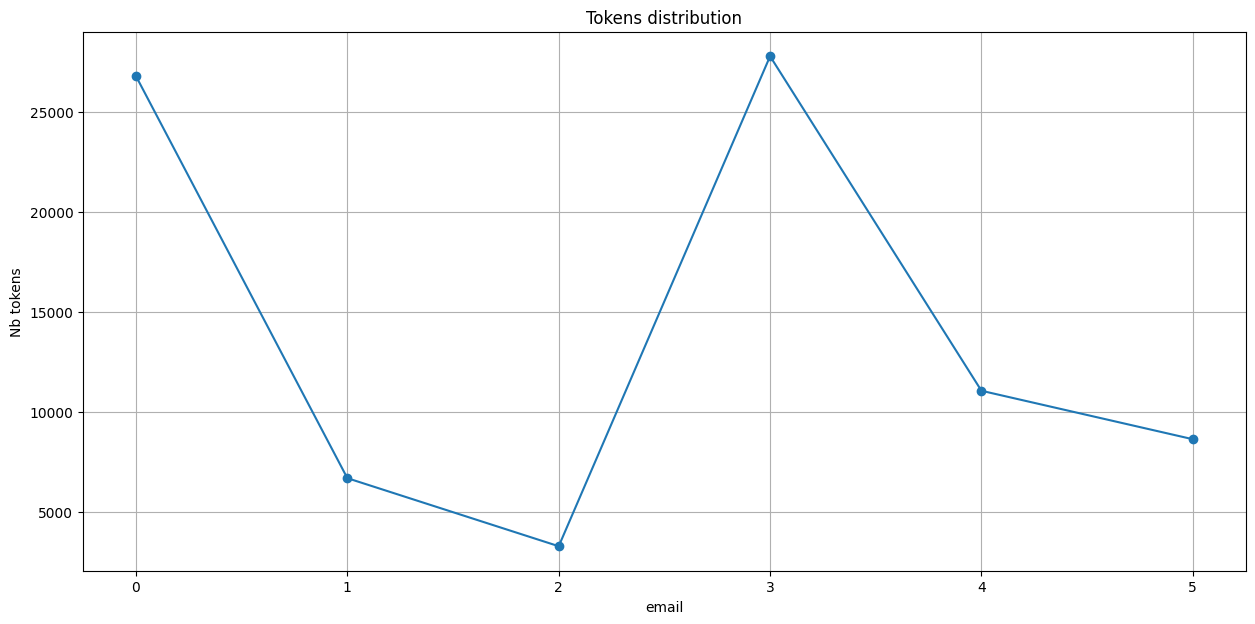

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(df["nb_tokens"], marker="o", linestyle="-")
plt.xlabel("email")
plt.ylabel("Nb tokens")
plt.title("Tokens distribution")
plt.grid(True)
plt.show()

In [25]:
excel_file = "myemails.xlsx"
df.to_excel(excel_file, sheet_name='emails')

!ls $excel_file -lh

-rwxrwxrwx 1 root root 33K Nov  9 10:34 myemails.xlsx
